In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import root
from tqdm import tqdm
from nozzle import Params, Nozzle, Boundary, Spectral

In [1]:
def rk4(f: callable, y0: np.array, t: np.array):
    """ RK4 with fixed time step """
    dt = t[1] - t[0]
    y = np.zeros((y0.size, t.size), dtype=y0.dtype)
    y[:,0] = y0
    for n in range(t.size-1):
        yn = y[:,n]
        tn = t[n]
        k1 = f(tn, yn)
        k2 = f(tn+dt/2, yn + dt*k1/2)
        k3 = f(tn+dt/2, yn + dt*k2/2)
        k4 = f(tn+dt, yn + dt*k3)
        y[:,n+1] = yn + dt*(k1+2*k2+2*k3+k4)/6
    return t, y

NameError: name 'np' is not defined

The coupled first order system is
$$
\begin{align*}
\frac{dv}{dz} &= a \\
\frac{da}{dz} &= -\frac{1}{1-v_0^2} \left[ 
    \omega^2v 
    + 2i\omega \left(a + \frac{dv_0}{dz}v\right) 
    - \left( 3v_0+\frac{1}{v_0} \right) \frac{dv_0}{dz}a
    - \left( 1+\frac{1}{v_0^2} \right) \left(\frac{dv_0}{dz}\right)^2v
    - \left( v_0+\frac{1}{v_0} \right) \frac{d^2v_0}{dz^2}v
\right]
\end{align*}
$$

In [122]:
Mm = 1.0
constant_v = False
accelerating = False
boundary = Boundary.FIXED_OPEN
params = Params(Mm, constant_v, accelerating, boundary)
spectral = Spectral(500, "symmetric", "FD") # use even number to skip z=0, and odd number to include z=0
nozzle = Nozzle(params, spectral.x)
v0 = nozzle.v0
v0_p = spectral.D1 @ v0
v0_pp = spectral.D2 @ v0

# spectral.x has all midpoints
x = np.linspace(-1,1,(spectral.x.size+1)//2) # remove the midpoints

def nozzle_ivp(z,y, w):
    """ return R.H.S. of the coupled first order system at a point """
    ind = np.argmin(np.abs(spectral.x-z))
    v, a = y[0], y[1]
    rhs = np.zeros(2, dtype=complex)
    rhs[0] = a
    rhs[1] = w**2*v + 2j*w*(v0[ind]*a + v0_p[ind]*v) - (3*v0[ind]+1/v0[ind])*v0_p[ind]*a - (1+1/v0[ind]**2)*(v0_p[ind])**2*v - (v0[ind]+1/v0[ind])*v0_pp[ind]*v
    rhs[1] /= -(1-v0[ind]**2)
    return rhs

In [125]:
def nozzle_rfp(w):
    """ Given eigenvalue w (in array form), returns v(1) or v'(1) """
    w = w[0] + w[1]*1j
    y0 = np.array([0,1], dtype=complex)    
    z, y = rk4(
        lambda z,y: nozzle_ivp(z,y, w),
        y0,
        x
    )
    if boundary == Boundary.FIXED_FIXED:
        pass
    elif boundary == Boundary.FIXED_OPEN:
        v = y[0,:]
        dz = z[1] - z[0]
        v_p = (3*v[-1] - 4*v[-2] + v[-3]) / (2*dz)
        return np.array([v_p.real, v_p.imag])

# omega0_arr = np.arange(1,6,dtype=complex)
omega0_arr = [2+0j, 5+0j, 10+0j, 15+0j]
omega = np.zeros_like(omega0_arr)
for n, w0 in enumerate(tqdm(omega0_arr)):
    w0 = np.array([w0.real, w0.imag])
    result = root(nozzle_rfp, w0, tol=1e-12)
    print(result.success) 
    w = result.x
    omega[n] = w[0]+w[1]*1j

 25%|██▌       | 1/4 [00:00<00:01,  1.65it/s]

True


 50%|█████     | 2/4 [00:00<00:00,  2.37it/s]

True


 75%|███████▌  | 3/4 [00:01<00:00,  1.97it/s]

True


100%|██████████| 4/4 [00:02<00:00,  1.70it/s]

True


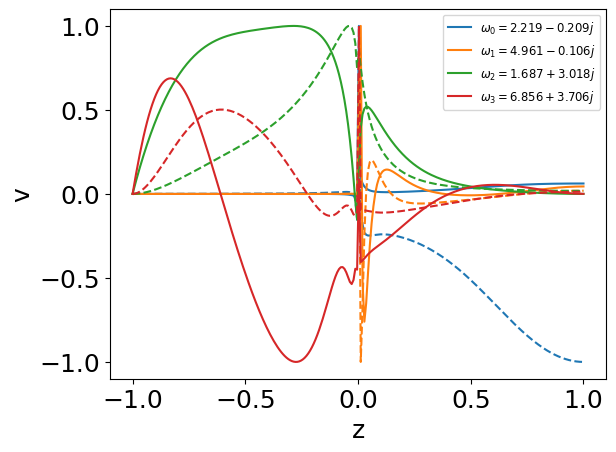

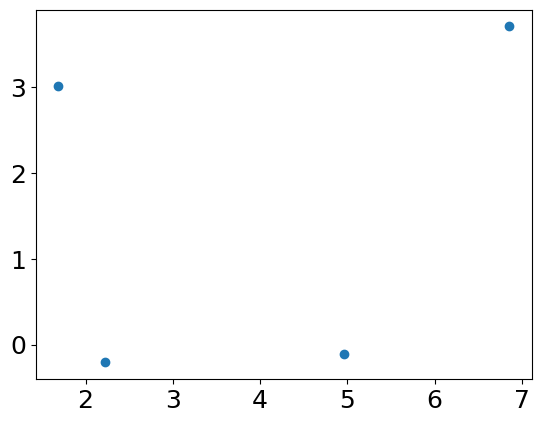

In [126]:
plt.figure()
for n, w in enumerate(omega):
    z, y = rk4(
        lambda z,y: nozzle_ivp(z,y, w),
        np.array([0,1], dtype=complex),
        x
    )

    v = y[0]
    line = plt.plot(z, v.real / np.abs(v.real).max(), label=f"$\omega_{n}={omega[n]:.3f}$")
    plt.plot(z, v.imag / np.abs(v.imag).max() , "--", color=line[-1].get_color())
plt.legend(fontsize="small")
plt.xlabel("z")
plt.ylabel("v")

plt.figure()
plt.plot(omega.real, omega.imag, 'o')